# GIS Workflow Example
In the following notebook, I will walk you through the typicle steps performed when working with GIS Data. 

Note: the raster and vector files used below are actually part of a much larger raster and vector file. The steps used to segment the files are not shown in the notebook below.

In the notebook below we will go over the following steps:
* Creating masks from vector files
* Visualizing raster & vector data using folium
* Semantic segmentation for building footprint detection using pretrained model
* Comparison between predicted footprints, actual footprints 
* Preliminary Model Evaluation

## Import Package Dependencies
First thing we are going to do is import the necessary dependencies below:

In [18]:
import geopandas as gpd
import rasterio
import solaris as sol
from PIL import Image, ImageChops
import folium
from pathlib import Path 
import numpy as np
import json
import pandas as pd

## Loading in the necessary paths
Next we are going to be loading the necessary  paths that we are going to be accessing regularly.

In [24]:
# Load in directories
data_path = Path(Path.cwd()/'data')
chips_path = Path(data_path/'chips')
geoms_path = Path(data_path/'geoms')

# directory containing inference csv
inference_in_path = Path(Path.cwd()/'inference_in')

# directory containing output csv upon inferencing
inference_out_path = Path(Path.cwd()/'inference_out')

# directory containing yaml configuration files for model training
config_path = Path(Path.cwd()/'config')
xdxd_model_config_path = Path(config_path/'xdxd_spacenet4.yml')

# Load in files
chip_path = Path(chips_path/'013022232023_-43.494_-22.896.tif')
geom_path = Path(geoms_path/'geoms_-43.494_-22.896.geojson')

### Extract Bouding Box
The function below is a simple funcion that extracts the bounding box of a raster file given the path to that file. 

It returns the bouding box in the form of [[top left coords],[bottom right coords]]. The coordinate format depends on the crs of the input raster file.

In [3]:
def get_bbox(chip_path):
    with rasterio.open(chip_path) as c:
        bounds = c.bounds
    # [[top_left],[bottom_right]]
    bbox = [[bounds[3],bounds[0]],[bounds[1],bounds[2]]]
    return bbox
        

The function below will be used to read the image into a numpy array so that we can perform some manipulations on it.

In [4]:
def read_raster(chip_path):
    with rasterio.open(chip_path) as c:
        return c.read()

The function below returns the crs of the raster file give the path.

In [5]:
def get_crs(chip_path):
    with rasterio.open(chip_path) as c:
        return c.crs

The function below will be used to read geojson file and output it as json format.

In [6]:
def geojson_to_json(geom_path):
    with open(geom_path,'r') as g:
        geojson = g.read()
    return json.loads(geojson)    

## Create Folium Map Object

In [7]:
chip_bbox = get_bbox(chip_path)

In [8]:
map = folium.Map(
    location=chip_bbox[0],
    zoom_start=18)

### Convert raster to image
In order to plot raster image it needs to be converted from raster format (bands, rows, columns) to (rows, columns, bands) this can be done in rasterio using the functions below

In [9]:
from rasterio.plot import reshape_as_raster, reshape_as_image

In [10]:
raster = read_raster(chip_path)
raster.shape

(3, 512, 512)

In [11]:
image = reshape_as_image(raster)
image.shape

(512, 512, 3)

### Add raster layer on top base folium  map

In [12]:
folium.raster_layers.ImageOverlay(
    image=image,
    bounds=chip_bbox,
    opacity=0.6,
    name='raster'   
).add_to(map);

### Add vector layers on top of base folium map

In [13]:
folium.GeoJson(geojson_to_json(geom_path),name='vector').add_to(map);

### Add Layer control to toggle between the different layers

In [14]:
folium.LayerControl().add_to(map);

In [15]:
map

## Creating the csv for desired inference data

The Solaris framework accepts a csv containing the path to the images that you would like to infer using the model. This csv should have the a tile of 'image' and should NOT have an index! 

In [23]:
d = {'image':[chip_path]}
# Create DataFrame from dictionary
inference_df = pd.DataFrame.from_dict(d)
# Save data as csv
inference_df.to_csv(Path(inference_in_path/'infer.csv'),index=False)
# Path to infer csv
infer_csv = Path(inference_in_path/'infer.csv')

## Load & Configure Pretrained Model Configuration File

In [28]:
config = sol.utils.config.parse(xdxd_model_config_path)

### Inference Configuration

In [29]:
config['inference_data_csv'] =  str(infer_csv)
config['inference_data_csv']

'/home/solaris/inference_in/infer.csv'

In [34]:
inf_df = sol.nets.infer.get_infer_df(config)

## Load Model

In [31]:
xdxd_inferer = sol.nets.infer.Inferer(config)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



/opt/conda/envs/solaris/lib/python3.7/site-packages/solaris/nets/model_io.py:35: UserWarning: The model weights file /opt/conda/envs/solaris/lib/python3.7/site-packages/solaris/nets/weights/xdxd_spacenet4_solaris_weights.pth was not found. Attempting to download from the SpaceNet repository.
  warn(f'The model weights file {model_path} was not found.'


## Run Inference

In [35]:
model_result_mask = xdxd_inferer(inf_df[0:1])

/opt/conda/envs/solaris/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [38]:
output_path = Path(Path.cwd()/'xdxd_inference_out')
outputs = [p for p in output_path.iterdir()]

## Visualize output

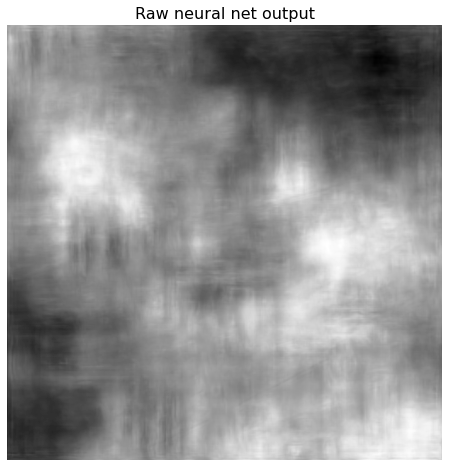

In [39]:
import matplotlib.pyplot as plt
import skimage

resulting_preds = skimage.io.imread(outputs[0])
plt.figure(figsize=(8, 8))
plt.imshow(resulting_preds, cmap='gray')
plt.axis('off')
plt.title('Raw neural net output', size=16);

### Change Output to Binary Form

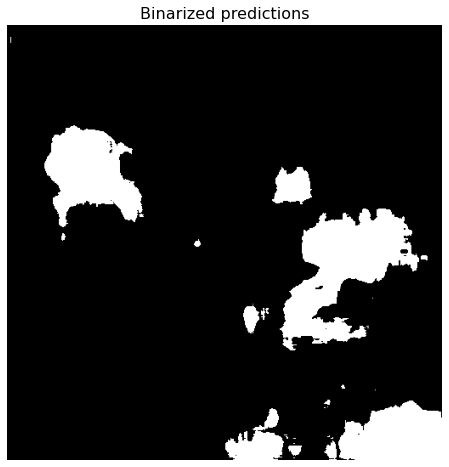

In [42]:
binary_preds = resulting_preds > 0
plt.figure(figsize=(8,8))
plt.imshow(binary_preds.astype('uint8'), cmap='gray')
plt.axis('off')
plt.title('Binarized predictions', size=16);

## Convert Image Output to Vector Format

In [44]:
from shapely.ops import cascaded_union  # just for visualization
predicted_footprints = sol.vector.mask.mask_to_poly_geojson(
    pred_arr=resulting_preds,
    reference_im=inf_df.loc[0, 'image'],
    do_transform=True)

cascaded_union(predicted_footprints['geometry'].values)

In [45]:
print(predicted_footprints['geometry'].head())


GeoSeries([], Name: geometry, dtype: geometry)
